In [1]:
# !python3 load_dataset.py  \
#     --orig_model_name_or_path bioelectra  \
#     --model_name_or_path kamalkraj/bioelectra-base-discriminator-pubmed-pmc-lt  \
#     --output_dir /net/kdinxidk03/opt/NFS/75y/data/qa/output/ \
#     --data_dir /net/kdinxidk03/opt/NFS/75y/data/qa/dataset_pos/emrqa/  \
#     --train_file train_emrqa_risk_adamrc.json \
#     --dataset_name emrqa_risk_adamrc  \
#     --do_lower_case \
#     --do_train \
#     --max_seq_length 384  \
#     --doc_stride 128  \
#     --overwrite_cache 


In [2]:
# !python3 load_dataset.py  \
#     --orig_model_name_or_path bioelectra  \
#     --model_name_or_path kamalkraj/bioelectra-base-discriminator-pubmed-pmc-lt  \
#     --output_dir /net/kdinxidk03/opt/NFS/75y/data/qa/output/ \
#     --data_dir /net/kdinxidk03/opt/NFS/75y/data/qa/dataset_pos/emrqa/  \
#     --predict_file test_emrqa_risk.json \
#     --dataset_name emrqa_risk  \
#     --do_lower_case \
#     --do_aevaluate \
#     --max_seq_length 384  \
#     --doc_stride 128  \
#     --overwrite_cache 


In [186]:
train = json.load(open('/net/kdinxidk03/opt/NFS/75y/data/qa/dataset_pos/emrqa/datasets/risk-dataset-train_70perc.json'))
test = json.load(open('/net/kdinxidk03/opt/NFS/75y/data/qa/dataset_pos/emrqa/datasets/risk-dataset-dev_30perc_seed42.json'))

In [247]:
len(train['data'])

83

In [245]:
# title_ls    = []
# context_ls  = []
# question_ls = []
# id_ls       = []
# answer_ls   = []

# for d in train['data']:
#   para  = d['paragraphs']
#   title = d['title']

#   for p in para:
#     context = p['context']
#     qas     = p['qas']
#     for q in qas:
#       question = q['question']
#       id_      = q['id']
#       answer   = q['answers']
      
#       if context not in context_ls: 
#         context_ls.append(context)
#         title_ls.append(title)
#         question_ls.append(question)
#         id_ls.append(id_)
#         answer_ls.append(answer)

      
      

In [248]:
# len(context_ls)==len(question_ls)==len(id_ls)==len(answer_ls)

True

In [250]:
# para = []
# for i, id_ in enumerate(id_ls):
#   para.append({'qas': [{'id': id_,
#                         'question': '[MASK]',
#                         'answers': answer_ls[i]}],
#                'context': context_ls[i]})

# print(len(para))


83


In [253]:
# json_file={
#           "data": [
#             {
#               "paragraphs":para,
#                "title":'emrQA-risk'
#             }],
#            "version":0
#        }

# with open('/net/kdinxidk03/opt/NFS/75y/data/qa/dataset_pos/emrqa/train_emrqa_risk.json', "w") as writer:
#     writer.write(json.dumps(json_file, indent=4) + "\n") 

In [254]:
# json.load(open('/net/kdinxidk03/opt/NFS/75y/data/qa/dataset_pos/emrqa/train_emrqa_risk.json'))

In [239]:
# import pickle
# pickle.dump(ex_id, open('TEXT_IDS_RISK.txt', 'wb'))

In [241]:
# aa = pickle.load(open('TEXT_IDS_RISK.txt', 'rb'))

In [242]:
# aa==ex_id

True

In [229]:
len(train['data']), len(test['data'])

(83, 35)

In [70]:
import torch
features_and_dataset = torch.load(
  '/net/kdinxidk03/opt/NFS/75y/data/qa/output/cached_dev_bioelectra_384_test_emrqa_risk_30perc_seed42'
)
features, dataset, examples = (
    features_and_dataset["features"],
    features_and_dataset["dataset"],
    features_and_dataset["examples"],
)


In [71]:
pred = json.load(open('/net/kdinxidk03/opt/NFS/75y/data/qa/output/predictions_emrqa_risk_30perc_seed42.json'))

In [72]:

import collections
import json
import math
import re
import string
import numpy as np


def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""

    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


def get_tokens(s):
    if not s:
        return []
    return normalize_answer(s).split()


def compute_exact(a_gold, a_pred):
    return int(normalize_answer(a_gold) == normalize_answer(a_pred))


def compute_f1(a_gold, a_pred):
    gold_toks = get_tokens(a_gold)
    pred_toks = get_tokens(a_pred)
    common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
    num_same = sum(common.values())
    if len(gold_toks) == 0 or len(pred_toks) == 0:
        # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
        return int(gold_toks == pred_toks)
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1
  
def get_raw_scores(examples, preds):
    """
    Computes the exact and f1 scores from the examples and the model predictions
    """
    exact_scores = {}
    f1_scores = {}

    for example in examples:
        qas_id = example.qas_id
        gold_answers = [answer["text"] for answer in example.answers if normalize_answer(answer["text"])]

        if not gold_answers:
            # For unanswerable questions, only correct answer is empty string
            gold_answers = [""]

        if qas_id not in preds:
            print(f"Missing prediction for {qas_id}")
            continue

        prediction = preds[qas_id]
        exact_scores[qas_id] = max(compute_exact(a, prediction) for a in gold_answers)
        f1_scores[qas_id] = max(compute_f1(a, prediction) for a in gold_answers)

    return exact_scores, f1_scores

em, f1 = get_raw_scores(examples, pred)

In [197]:
# 70-20-10

In [198]:
13996/3

4665.333333333333

In [201]:
import random

ct=0
s=0
idx = []
rest_idx = []
for i, x in enumerate(f1.values()):
  if x>0:
    idx.append(i)
    s+=x
    ct+=1
  else:
    rest_idx.append(i)

rest_idx = random.sample(rest_idx, len(rest_idx))
    
ct, s/ct, len(f1), len(examples), len(rest_idx)

(3817, 0.4451160838458363, 13996, 13996, 10179)

In [202]:
ids = idx+rest_idx[:(4665-3817)]
print(len(np.unique(ids)))

4665


In [203]:
(np.mean([list(f1.values())[i] for i in ids]),
 np.mean([list(em.values())[i] for i in ids])
)

(0.3642032351638966, 0.11211146838156484)

In [ ]:
# f1 = 0.3642032351638966
# em = 0.11211146838156484

In [221]:
ex = [examples[i] for i in ids]
len(ex)

4665

In [96]:
# pred

In [98]:
# ex[0].__dict__

In [210]:
ex_id = [e.__dict__['qas_id'] for e in ex]

In [211]:
len(ex_id)

4665

In [212]:
len(np.unique(ex_id))

4665

In [42]:
# json.load(open('/net/kdinxidk03/opt/NFS/75y/data/qa/output/predictions_emrqa_risk.json'))

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import configs

In [4]:
# !ls /net/kdinxidk03/opt/NFS/75y/data/OTMRC_PAPER/unsupervised_v2_fold1/

In [5]:
import random
random.randint(1,10)

9

In [897]:
# # path         = '/net/kdinxidk03/opt/NFS/75y/data/OTMRC_PAPER/unsupervised_v1/ansLen-200/'

# # path         = '/net/kdinxidk03/opt/NFS/75y/data/OTMRC_PAPER/unsupervised_v2_fold1/'
# # path         = '/net/kdinxidk03/opt/NFS/75y/data/OTMRC_PAPER/unsupervised_v2_fold2/'
# # path         = '/net/kdinxidk03/opt/NFS/75y/data/OTMRC_PAPER/unsupervised_v2_fold3/'
# # path         = '/net/kdinxidk03/opt/NFS/75y/data/OTMRC_PAPER/unsupervised_v2_fold4/'
# # path         = '/net/kdinxidk03/opt/NFS/75y/data/OTMRC_PAPER/unsupervised_v2_fold5/'

# # path         = '/net/kdinxidk03/opt/NFS/75y/data/OTMRC_PAPER/semisupervised_fold1/epoch-150/'
# # path         = '/net/kdinxidk03/opt/NFS/75y/data/OTMRC_PAPER/semisupervised_fold2/'
# # path         = '/net/kdinxidk03/opt/NFS/75y/data/OTMRC_PAPER/semisupervised_fold3/'
# # path         = '/net/kdinxidk03/opt/NFS/75y/data/OTMRC_PAPER/semisupervised_fold4/'
# # path         = '/net/kdinxidk03/opt/NFS/75y/data/OTMRC_PAPER/semisupervised_fold5/'

# path         = '/net/kdinxidk03/opt/NFS/75y/data/OTMRC_PAPER/supervised_fold1/final-aug13/'
# path         = '/net/kdinxidk03/opt/NFS/75y/data/OTMRC_PAPER/supervised_fold2/ansLen-200-epoch-100/'
path         = '/net/kdinxidk03/opt/NFS/75y/data/OTMRC_PAPER/supervised_fold3/final/'
# path         = '/net/kdinxidk03/opt/NFS/75y/data/OTMRC_PAPER/supervised_fold4/ansLen-200/'
# path         = '/net/kdinxidk03/opt/NFS/75y/data/OTMRC_PAPER/supervised_fold5/ansLen-200/'

# # path         = '/net/kdinxidk03/opt/NFS/75y/data/qa/output/biobert-adv/model-9B-bioelectra/final/'

# # path_B_squad = path+f'/qa-squad/sacc_lacc_mrr_epoch.txt'
# # path_B_adv   = path+f'/sacc_lacc_mrr_epoch.txt'

# # x, y, z      = 0.4510, 0.6419, 0.5165
# # x, y, z      = 0.3937, 0.6098, 0.4688
# # x, y, z      = 0.5399, 0.7300, 0.6017

In [898]:
# with open(path_B_squad, 'r') as f:
#     result_epoch_squad = f.readlines()
# with open(path_B_adv, 'r') as f:
#     result_epoch_adv = f.readlines()

# sacc_squad, lacc_squad, mrr_squad = [], [], []
# for i in range(len(result_epoch_squad)):
#   res = list(map(float, result_epoch_squad[i].split(',')))
#   sacc_squad.append(res[0])
#   lacc_squad.append(res[1])
#   mrr_squad.append(res[2])

# sacc_adv, lacc_adv, mrr_adv = [], [], []
# for i in range(len(result_epoch_adv)):
#   res = list(map(float, result_epoch_adv[i].split(',')))
#   sacc_adv.append(res[0])
#   lacc_adv.append(res[1])
#   mrr_adv.append(res[2])


# plt.figure(figsize = (15,15))
# plt.plot(range(len(sacc_squad)), sacc_squad, 'o-', label = 'SAcc-SQUAD', alpha=0.4)
# plt.plot(range(len(lacc_squad)), lacc_squad, 'o-', label = 'LAcc-SQUAD', alpha=0.4)
# plt.plot(range(len(mrr_squad)),  mrr_squad,  'o-', label = 'MRR-SQUAD', alpha=0.4)

# plt.plot(range(len(sacc_adv)), sacc_adv, 'o-', label = 'SAcc-ADV', alpha=0.3)
# plt.plot(range(len(lacc_adv)), lacc_adv, 'o-', label = 'LAcc-ADV', alpha=0.3)
# plt.plot(range(len(mrr_adv)),  mrr_adv,  'o-', label = 'MRR-ADV', alpha=0.3)


# from scipy.ndimage import gaussian_filter1d
# sigma = 3
# sacc_gauss = gaussian_filter1d(sacc_squad, sigma=sigma)
# lacc_gauss = gaussian_filter1d(lacc_squad, sigma=sigma)
# mrr_gauss  = gaussian_filter1d(mrr_squad, sigma=sigma)
# plt.plot(range(len(sacc_gauss)), sacc_gauss, '-', label = 'SAcc-SQUAD')
# plt.plot(range(len(lacc_gauss)), lacc_gauss, '-', label = 'LAcc-SQUAD')
# plt.plot(range(len(mrr_gauss)),  mrr_gauss,  '-', label = 'MRR-SQUAD')

# sacc_gauss1 = gaussian_filter1d(sacc_adv, sigma=sigma)
# lacc_gauss1 = gaussian_filter1d(lacc_adv, sigma=sigma)
# mrr_gauss1  = gaussian_filter1d(mrr_adv, sigma=sigma)
# plt.plot(range(len(sacc_gauss1)), sacc_gauss1, '-', label = 'SAcc-ADV')
# plt.plot(range(len(lacc_gauss1)), lacc_gauss1, '-', label = 'LAcc-ADV')
# plt.plot(range(len(mrr_gauss1)),  mrr_gauss1,  '-', label = 'MRR-ADV', )

# plt.plot(range(len(sacc_adv)), [x]*len(sacc_adv), '--b', alpha=0.4)
# plt.plot(range(len(lacc_adv)), [y]*len(lacc_adv), '--r', alpha=0.4)
# plt.plot(range(len(mrr_adv)),  [z]*len(mrr_adv),  '--g', alpha=0.4)

# plt.scatter([len(sacc_adv)-1], [x], marker='*', s=500)
# plt.scatter([len(lacc_adv)-1], [y], marker='*', s=500)
# plt.scatter([len(mrr_adv)-1],  [z], marker='*', s=500)

# plt.legend(loc='best')
# plt.show()


In [899]:

# model-7B-bioelectra/qa-disc-with-aux/ --- 100 epochs, lr_step = 20
# model-7B-bioelectra/qa-disc-with-aux-1/ --- 100 epochs, learning_rate_step = 10
# model-7B-bioelectra/qa-disc-with-aux-2/ --- 100 epochs, learning_rate_step = 1
# model-7B-bioelectra/qa-disc-with-aux-3/ --- 200 epochs, lr_step = 1

# 9B -- epoch 149
# 7B -- epoch 
# 8B -- epoch 156

# model-8B-bioelectra/qa-disc-with-aux-2

In [900]:
# import os
# import shutil
# shutil.rmtree("/net/kdinxidk03/opt/NFS/75y/data/qa/output/REVISION/REVIEWER-2/model-9B/FINAL-WITH-AUX/squad-all-samples/RUN-2/")

In [901]:
main_path = path

loss_path   = path+'loss_epochs.txt'


In [902]:
# import configs
# print(configs.lr_multiplier)

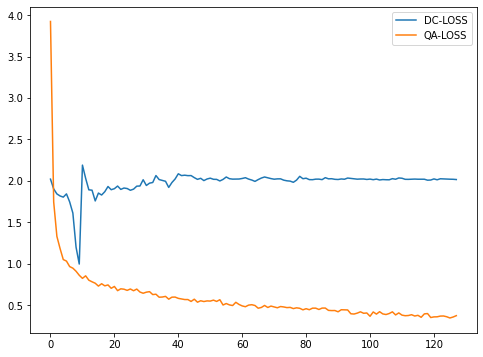

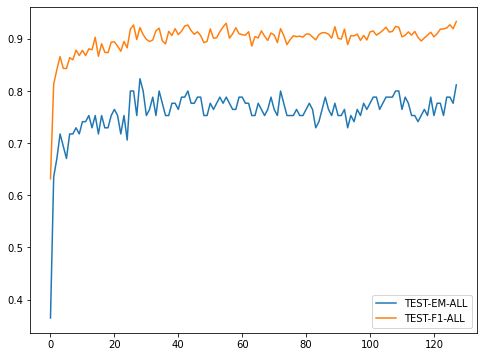

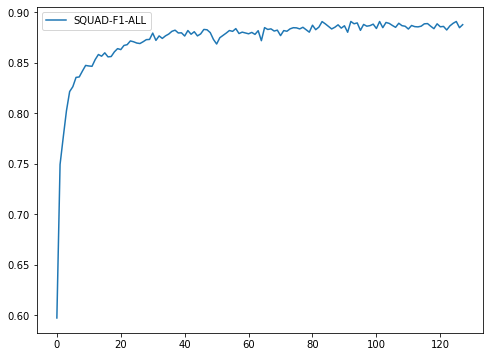

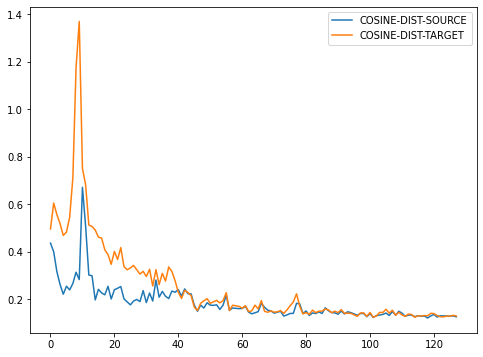

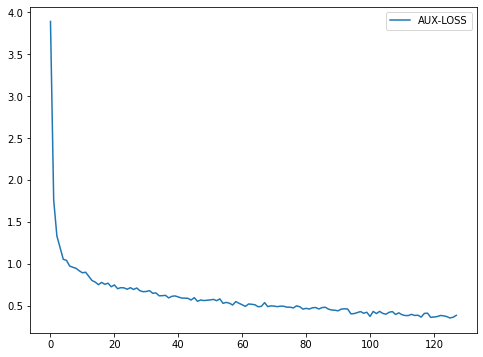

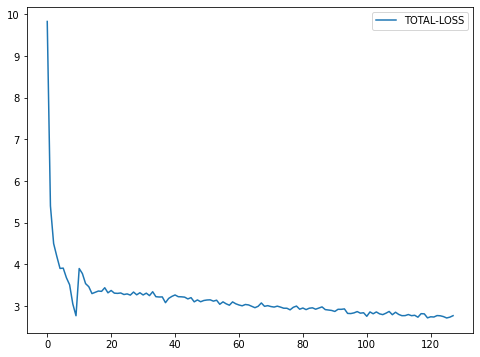

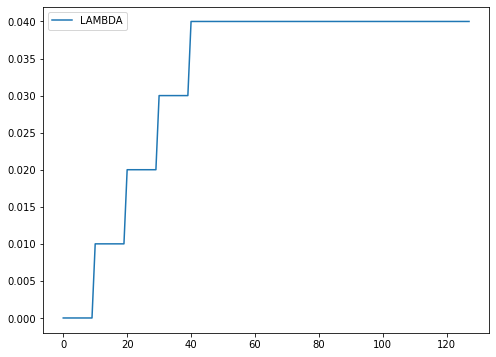

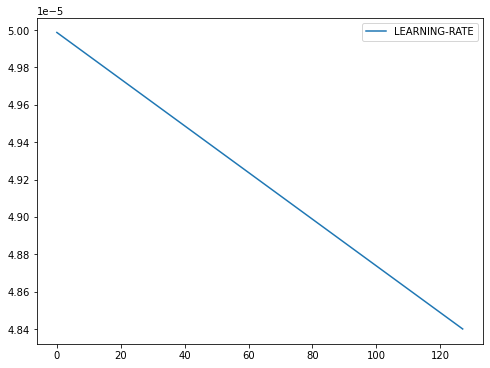

28 82.35294117647058
28 92.17448845572024
127 81.17647058823529
127 93.33374281151438


In [903]:
with open(loss_path, 'r') as f:
    loss = f.readlines()

lr      = list(map(float, loss[0][1:-2].split(',')))
dc_loss = list(map(float, loss[1][5:-2].split(',')))
au_loss = list(map(float, loss[2][1:-2].split(',')))
qa_loss = list(map(float, loss[3][1:-2].split(',')))
to_loss = list(map(float, loss[4][1:-2].split(',')))
la      = list(map(float, loss[5][1:-2].split(',')))
val_loss= loss[6][1:-2]
cosDist_source = list(map(float, loss[7][1:-2].split(',')))
cosDist_target = list(map(float, loss[8][1:-2].split(',')))
squad_em  = loss[9][1:-2]
squad_f1  = loss[10][1:-2]
val_loss_all  = loss[11][1:-2].split(',')
squad_em_all  = list(map(float, loss[12][1:-2].split(',')))
squad_f1_all  = list(map(float, loss[13][1:-2].split(',')))

test_em_all  = list(map(float, loss[14][1:-2].split(',')))
test_f1_all  = list(map(float, loss[15][1:-2].split(',')))

# val_loss = [x/2.0 for x in val_loss]

# {bioasq_val_loss_list}\n{squad_bioasq_val_mean_loss_list}\n{squad_bioasq_val_weighted_mean_loss_list}\n{squad_em_list}\n{squad_f1_list}\n{bioasq_em_list}\n{bioasq_f1_list}\n

# print(dc_loss)
# print('\n')

# print(qa_loss[:15])
# print('\n')

# print(au_loss)
# print('\n')

# print(lr)
# print('\n')

# print(to_loss)
# print('\n')

# print(la)
# print('\n')

import matplotlib.pyplot as plt

plt.figure(figsize = (8,6))
plt.plot(range(len(dc_loss[:])), dc_loss[:],
#          'o-',
         label = 'DC-LOSS')
plt.plot(range(len(qa_loss[:])), qa_loss[:],
#          'o-',
         label = 'QA-LOSS')
# plt.plot(range(len(val_loss[:])), val_loss[:],
# #          'o-',
#          label = 'VALIDATION-LOSS')
# plt.plot(range(len(val_loss_all[:])), val_loss_all[:],
# #          'o-',
#          label = 'VALIDATION-LOSS-ALL')
plt.legend(loc='best')
plt.show()


plt.figure(figsize = (8,6))
plt.plot(range(len(test_em_all[:])), 
         test_em_all[:],
#          'o-',
         label = 'TEST-EM-ALL')
plt.plot(range(len(test_f1_all[:])), 
         test_f1_all[:],
#          'o-',
         label = 'TEST-F1-ALL')
plt.legend(loc='best')
plt.show()


plt.figure(figsize = (8,6))
# plt.plot(range(len(squad_em[:])), 
#          squad_em[:],
# #          'o-',
#          label = 'SQUAD-EM')
# plt.plot(range(len(squad_f1[:])), 
#          squad_f1[:],
# #          'o-',
#          label = 'SQUAD-F1')
# plt.plot(range(len(squad_em_all[:])), 
#          squad_em_all[:],
# #          'o-',
#          label = 'SQUAD-EM-ALL')
plt.plot(range(len(squad_f1_all[:])), 
         squad_f1_all[:],
#          'o-',
         label = 'SQUAD-F1-ALL')
plt.legend(loc='best')
plt.show()

plt.figure(figsize = (8,6))
plt.plot(range(len(cosDist_source)), cosDist_source,
#          'o-',
         label = 'COSINE-DIST-SOURCE')
plt.plot(range(len(cosDist_target)), cosDist_target,
#          'o-',
         label = 'COSINE-DIST-TARGET')
plt.legend(loc='best')
plt.show()

# plt.figure(figsize = (8,6))
# plt.plot(range(len(val_loss)), val_loss, 'o-', label = 'VALIDATION-LOSS')
# plt.legend(loc='best')
# plt.show()

plt.figure(figsize = (8,6))
plt.plot(range(len(au_loss)), au_loss[:],
#          'o-',
         label = 'AUX-LOSS')
plt.legend(loc='best')
plt.show()

plt.figure(figsize = (8,6))
plt.plot(range(len(to_loss)), to_loss,
#          'o-',
         label = 'TOTAL-LOSS')
plt.legend(loc='best')
plt.show()

plt.figure(figsize = (8,6))
plt.plot(range(len(la)), la,
#          'o-',
         label = 'LAMBDA')
plt.legend(loc='best')
plt.show()

plt.figure(figsize = (8,6))
plt.plot(range(len(lr)), lr,
#          'o-',
         label = 'LEARNING-RATE')
plt.legend(loc='best')
plt.show()


em_high_ind = test_em_all[:].index(max(test_em_all[0:]))
f1_high_ind = test_f1_all[:].index(max(test_f1_all[0:]))

print(em_high_ind, test_em_all[em_high_ind]*100)

print(em_high_ind, test_f1_all[em_high_ind]*100)

print(f1_high_ind, test_em_all[f1_high_ind]*100)
      
print(f1_high_ind, test_f1_all[f1_high_ind]*100)


In [896]:
for i,x in enumerate(test_f1_all):
  print(i, x, test_em_all[i])

0 0.6316634917930444 0.36470588235294116
1 0.8130751369061705 0.6352941176470588
2 0.8413967830437935 0.6705882352941176
3 0.8659919071296226 0.7176470588235294
4 0.8433573770056833 0.6941176470588235
5 0.8431003210469635 0.6705882352941176
6 0.8638659493685417 0.7176470588235294
7 0.8597147203178699 0.7176470588235294
8 0.8784654242947606 0.7294117647058823
9 0.8680924908076403 0.7176470588235294
10 0.8779596250708046 0.7411764705882353
11 0.8679065678592973 0.7411764705882353
12 0.8808864395359455 0.7529411764705882
13 0.8790695136705768 0.7294117647058823
14 0.9030165017340186 0.7529411764705882
15 0.8665604094378975 0.7176470588235294
16 0.8906208884270684 0.7529411764705882
17 0.8743186493331139 0.7294117647058823
18 0.8733384050174681 0.7294117647058823
19 0.8935403059487806 0.7529411764705882
20 0.8943275621058799 0.7647058823529411
21 0.8859860696516836 0.7529411764705882
22 0.8762226908955619 0.7176470588235294
23 0.8950551090321416 0.7529411764705882
24 0.8827424276032855 0.7

In [888]:
# for i,x in enumerate(test_f1_all):
#   print(i, x, test_em_all[i])

In [24]:
test_em_all[61], test_f1_all[61], 

(0.706140350877193, 0.8464600734551977)

In [25]:
# from transformers import AutoModelForQuestionAnswering, AutoTokenizer
# m = AutoTokenizer.from_pretrained('michiyasunaga/BioLinkBERT-base')

In [26]:
# m.encode('[MASK]')

In [27]:
for i in range(5):
  a = json.load(open(f'/net/kdinxidk03/opt/NFS/75y/data/qa/dataset_pos/otquad/test_otquad_fold_{i+1}.json'))
  print(len(a['data']))
  
# 85
# 158
# 241
# 228
# 385

85
158
241
228
385


In [28]:
# with open(perf_path_2, 'r') as f:
#     result_epoch_pres_3 = f.readlines()

# #   if path_2:
# #     with open(path_2, 'r') as f:
# #         result_epoch_pres_3_2 = f.readlines()
# #     result_epoch_pres_3 = result_epoch_pres_3+result_epoch_pres_3_2

# print(len(result_epoch_pres_3))

# #   result_epoch_pres_3 = result_epoch_pres_3[:10]

# sacc, lacc, mrr = [], [], []
# for i in range(len(result_epoch_pres_3)):
#   res = list(map(float, result_epoch_pres_3[i].split(',')))
# #   print(res)
#   sacc.append(res[0]) #-0.3937)
#   lacc.append(res[1]) #-0.6098)
#   mrr.append(res[2]) #-0.4688)

In [29]:
# 10570 columns
# writerow per epoch

In [250]:
# # importing the csv module
# import csv
	
# # my data rows as dictionary objects
# mydict =[{'branch': 'COE', 'cgpa': '9.0', 'name': 'Nikhil', 'year': '2'},
# 		{'branch': 'COE', 'cgpa': '9.1', 'name': 'Sanchit', 'year': '2'},
# 		{'branch': 'IT', 'cgpa': '9.3', 'name': 'Aditya', 'year': '2'},
# 		{'branch': 'SE', 'cgpa': '9.5', 'name': 'Sagar', 'year': '1'},
# 		{'branch': 'MCE', 'cgpa': '7.8', 'name': 'Prateek', 'year': '3'},
# 		{'branch': 'EP', 'cgpa': '9.1', 'name': 'Sahil', 'year': '2'}]
	

# import csv
# with open("sample.csv", "w") as csvFile:
#     fieldnames = ['name', 'branch', 'year', 'cgpa']
#     writer = csv.DictWriter(csvFile, fieldnames=fieldnames)
#     writer.writeheader()

#     for item in mydict:
#       writer.writerow(item)

In [251]:
# v = 9999
# for i,val in enumerate(val_loss):
#   if v > val:
#     print(i, '\t', val, '\t', sacc[i], '\t', lacc[i], '\t', mrr[i])
#     v = val
# print(val_loss[107])

# # d(a,s) = 0
# # d(a,t) = 2
# # margin = 1 (1-0 (cos90)), distance between anchor and 

In [252]:
val_loss_all[:].index(min(val_loss_all[:])), min(val_loss_all), len(val_loss_all), val_loss_all[-1]

(val_loss_all[:].index(min(val_loss_all[:])),
#  min(val_loss), len(val_loss), val_loss[-1],
 squad_em_all.index(max(squad_em_all)),
 squad_f1_all.index(max(squad_f1_all)),
)

# bio9b validation banabo
# 4 ta accuracy -- squad, bioasq, squad+bioasq/2, weighted mean
# loss, f1, em, sacc, lacc, mrr
# validation set index save kore rakhbo

(1, 130, 130)

In [253]:
ite_ls = []
vv = 0
for i, v in enumerate(squad_f1_all):
  if vv <= v:
    vv = v
    if i >=50:
      ite_ls.append(i)
      print(i , v)
      

62 0.8766782131083535
67 0.8801422644860082
84 0.8826271669210076
92 0.8826891348085057
99 0.8849683240992413
130 0.885372627966286


In [254]:
ite_ls

# 107 - 0.007386303682599979    0.2827645471446211
# 

[62, 67, 84, 92, 99, 130]

In [16]:
# import configs
# print(configs.trained_model_name)

In [17]:
# json.load(open('/net/kdinxidk03/opt/NFS/75y/data/qa/output/REVISION/REVIEWER-2/emrqa/medication/nbest_predictions_emrqa_med_ours.json'))

In [18]:
# vv = 0
# for i, v in enumerate(squad_f1_all):
# #   print(i, '\t', v)
#   if round(vv, 3) <= round(v, 3):
#     vv = round(v, 3)
#     print(i , '\t', round(v, 3))

In [19]:
# epoch_ls

In [20]:
# vv = 9999
# for i, v in enumerate(val_loss_all):
# #   print(i, '\t', v)
#   if round(vv, 3) >= round(v, 3):
#     vv = round(v, 3)
#     print(i , '\t', round(v, 3))

In [21]:
len(squad_f1_all)

51

In [23]:
(cosDist_source[-1], cosDist_target[-1],
cosDist_source.index(min(cosDist_source)), 
 cosDist_target.index(min(cosDist_target)))

(0.8449082076044793, 0.6063719890699103, 5, 27)

In [24]:
def plot_lacc_sacc_mrr(path_1, path_2, x, y, z, given_idx, n):

  print('BEST EPOCH:  ', given_idx)
  
  with open(path_1, 'r') as f:
      result_epoch_pres_3 = f.readlines()
      
#   if path_2:
#     with open(path_2, 'r') as f:
#       . c  result_epoch_pres_3_2 = f.readlines()
#     result_epoch_pres_3 = result_epoch_pres_3+result_epoch_pres_3_2
      
  print(len(result_epoch_pres_3))
  
#   result_epoch_pres_3 = result_epoch_pres_3[:10]

  sacc, lacc, mrr = [], [], []
  for i in range(len(result_epoch_pres_3)):
    res = list(map(float, result_epoch_pres_3[i].split(',')))
  #   print(res)
    sacc.append(res[0]) #-0.3937)
    lacc.append(res[1]) #-0.6098)
    mrr.append(res[2]) #-0.4688)

  print('BEST SCORES: ', sacc[given_idx], 
        lacc[given_idx],
        mrr[given_idx],
       )

#   for i in range(len(sacc)):
#     print(i, sacc[i], lacc[i], mrr[i])
#     print('\n\n')
    
#   print(lacc[-4:])
#   print('\n')

#   print(mrr[-4:])
#   print('\n')

#   print(sacc[-4:])
#   print('\n')

  plt.figure(figsize = (15,8))
  plt.plot(range(len(sacc[:n])), sacc[:n], 'o-', label = 'SAcc', alpha=0.4)
  plt.plot(range(len(lacc[:n])), lacc[:n], 'o-', label = 'LAcc', alpha=0.4)
  plt.plot(range(len(mrr[:n])),  mrr[:n],  'o-', label = 'MRR', alpha=0.4)

#   print(max(sacc), max(lacc), max(mrr),
#         sacc.index(max(sacc)),
#         lacc.index(max(lacc)),
#         mrr.index(max(mrr)))
  
  indx = mrr[:n].index(max(mrr[:n]))
  print(indx,
        sacc[indx],
        lacc[indx],
        mrr[indx],
       )
  
  indxx = sacc[:n].index(max(sacc[:n]))
  print(indxx,
        sacc[indxx],
        lacc[indxx],
        mrr[indxx],
       )
  
  indxxx = lacc[:n].index(max(lacc[:n]))
  print(indxxx,
        sacc[indxxx],
        lacc[indxxx],
        mrr[indxxx],
       )
  
  from scipy.ndimage import gaussian_filter1d
  sigma = 5
  sacc = gaussian_filter1d(sacc, sigma=sigma)
  lacc = gaussian_filter1d(lacc, sigma=sigma)
  mrr  = gaussian_filter1d(mrr, sigma=sigma)
  plt.plot(range(len(sacc[:n])), sacc[:n], '-', 
#            label = 'SAcc'
          )
  plt.plot(range(len(lacc[:n])), lacc[:n], '-', 
#            label = 'LAcc'
          )
  plt.plot(range(len(mrr[:n])),  mrr[:n],  '-', 
#            label = 'MRR'
          )

  # plt.plot(range(len(sacc)), [0.2857]*len(sacc), '-.b', alpha=0.4)
  # plt.plot(range(len(lacc)), [0.4643]*len(lacc), '-.r', alpha=0.4)
  # plt.plot(range(len(mrr)),  [0.3435]*len(mrr), '-.g', alpha=0.4)

  plt.plot(range(len(sacc[:n])), [x]*len(sacc[:n]), '--b', alpha=0.4)
  plt.plot(range(len(lacc[:n])), [y]*len(lacc[:n]), '--r', alpha=0.4)
  plt.plot(range(len(mrr[:n])),  [z]*len(mrr[:n]),  '--g', alpha=0.4)

  plt.scatter([len(sacc[:n])-1], [x], marker='*', s=500,
  #             label = 'SAcc'
             )
  plt.scatter([len(lacc[:n])-1], [y], marker='*', s=500,
#               label = 'LAcc'
             )
  plt.scatter([len(mrr[:n])-1],  [z], marker='*', s=500,
  #             label = 'MRR'
             )

  # plt.scatter([0], [0.2857], marker='p', 
  #             s=500, c='b',
  # #             label = 'SAcc-Baseline'
  #            )
  # plt.scatter([0], [0.4643], marker='p', 
  #             s=500, c='orange',
  # #             label = 'LAcc-Baseline'
  #            )
  # plt.scatter([0],  [0.3435], marker='p', 
  #             s=500, c='g'
  # #             label = 'MRR-Baseline'
  #            )

  plt.legend(loc='best')
  plt.show()

# [0.2857142857142857, 0.42857142857142855, 0.42857142857142855, 0.42857142857142855, 0.42857142857142855, 0.4642857142857143, 0.4642857142857143, 0.4642857142857143, 0.5, 0.42857142857142855]


# [0.2261904761904762, 0.33154761904761904, 0.3363095238095238, 0.35833333333333334, 0.34761904761904766, 0.33571428571428574, 0.3428571428571428, 0.34166666666666673, 0.3464285714285714, 0.3363095238095238]


# [0.17857142857142858, 0.2857142857142857, 0.2857142857142857, 0.32142857142857145, 0.32142857142857145, 0.2857142857142857, 0.2857142857142857, 0.2857142857142857, 0.2857142857142857, 0.2857142857142857]



In [ ]:
# plot_lacc_sacc_mrr(path_7B, None, 0.4510, 0.6419, 0.5165)

In [ ]:
# plot_lacc_sacc_mrr(path_8B, None, 0.3937, 0.6098, 0.4688)

In [ ]:
# plot_lacc_sacc_mrr(path_9B, None, 0.5399, 0.7300, 0.6017)

In [ ]:
# 1000 // 32 * 100

# 1000 // 32 * 200

# # len(train_dataloader) // configs.gradient_accumulation_steps * configs.num_train_epochs

In [ ]:
# plot_lacc_sacc_mrr(perf_path_2, None, 0.5399, 0.7300, 0.6017)

In [ ]:
# plot_lacc_sacc_mrr(perf_path_2, None, 0.4510, 0.6419, 0.5165)

In [ ]:
# a = 29
# b = 34
# c = 36
# d = 28
# e = 36

# sm = a+b+c+d+e
# print((a*0.4138+b*0.5000+c*0.5833+d*0.6429+e*0.5556)/sm)
# print((a*0.5862+b*0.7941+c*0.7222+d*0.8214+e*0.7222)/sm)
# print((a*0.4632+b*0.6127+c*0.6319+d*0.6929+e*0.6019)/sm)


In [ ]:
# plot_lacc_sacc_mrr(perf_path_2, None, 0.3937, 0.6098, 0.4688)

In [ ]:
# plot_lacc_sacc_mrr(path1, None, 0.4138, 0.5862, 0.4632)

In [ ]:
# plot_lacc_sacc_mrr(path2, None, 0.5000, 0.7941, 0.6127)

In [ ]:
# plot_lacc_sacc_mrr(path3, None, 0.5833, 0.7222, 0.6319)

In [ ]:
# plot_lacc_sacc_mrr(path4, None, 0.6429, 0.8214, 0.6929)

In [ ]:
# plot_lacc_sacc_mrr(path5, None, 0.5556, 0.7222, 0.6019)

In [ ]:
# (max(sacc), max(lacc), max(mrr), 
#  sacc.index(max(sacc)),
#  lacc.index(max(lacc)),
#  mrr.index(max(mrr)),
# #  sacc[22], lacc[22], mrr[22]
# )

In [ ]:
# !python3 transform_n2b_factoid.py --nbest_path /net/kdinxidk03/opt/NFS/75y/data/qa/output/nbest_predictions_test_bioasq_8b_3.json --output_path /net/kdinxidk03/opt/NFS/75y/data/qa/output/BioASQform_BioASQ-answer.json

In [ ]:
json.load(open('/net/kdinxidk03/opt/NFS/75y/data/qa/output/BioASQform_BioASQ-answer.json'))

In [ ]:
json.load(open('/net/kdinxidk03/opt/NFS/75y/data/qa/output/nbest_predictions_test_bioasq_8b_3.json'))

In [ ]:
# with open(path1, 'r') as f1:
#     result_epoch_pres_1 = f1.readlines()
# print(
#   list(
#     map(
#       float,
#       result_epoch_pres_1[-1].replace('\n', '').split(','))
#   )
# )

# with open(path2, 'r') as f2:
#     result_epoch_pres_2 = f2.readlines()
# print(
#   list(
#     map(
#       float,
#       result_epoch_pres_2[-1].replace('\n', '').split(','))
#   )
# )

# with open(path3, 'r') as f3:
#     result_epoch_pres_3 = f3.readlines()
# print(
#   list(
#     map(
#       float,
#       result_epoch_pres_3[-1].replace('\n', '').split(','))
#   )
# )

# with open(path4, 'r') as f4:
#     result_epoch_pres_4 = f4.readlines()
# print(
#   list(
#     map(
#       float,
#       result_epoch_pres_4[-1].replace('\n', '').split(','))
#   )
# )

# with open(path5, 'r') as f5:
#     result_epoch_pres_5 = f5.readlines()
# print(
#   list(
#     map(
#       float,
#       result_epoch_pres_5[-1].replace('\n', '').split(','))
#   )
# )

In [ ]:
import json
p = json.load(open('/net/kdinxidk03/opt/NFS/75y/data/qa/dataset_pos/bioasq/BioASQ-8b/train_bioasq.json'))

In [ ]:
len(p['data'][0]['paragraphs'])